In [1]:
import config, src
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

In [2]:
data = src.load_data(config.PROCESSED_DATA_COMBINED_RAP_HIPHOP_FILE)

X_train, X_test, y_train, y_test = src.split_data(data, target_column='music_genre')

class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight = dict(zip(np.unique(y_train), class_weight))

Données chargées avec succès.


In [3]:
forest_default = RandomForestClassifier(random_state=0, oob_score=True, n_jobs=-1, class_weight=class_weight)
forest_default.fit(X_train, y_train)

RandomForestClassifier(class_weight={np.int64(0): np.float64(1.11333778668448),
                                     np.int64(1): np.float64(1.120636521544237),
                                     np.int64(2): np.float64(1.116975231074251),
                                     np.int64(3): np.float64(1.0987501716797143),
                                     np.int64(4): np.float64(1.107235785860599),
                                     np.int64(5): np.float64(1.113616748795902),
                                     np.int64(6): np.float64(1.1069600110696),
                                     np.int64(7): np.float64(0.557297109021247),
                                     np.int64(8): np.float64(1.104758748308338)},
                       n_jobs=-1, oob_score=True, random_state=0)

----------------------------------------------------------------------------------------------------

Global accuracy : 0.6626
Global log loss : 1.1069044284019016
Global precision : 0.6408705396812034
Global recall : 0.6381686668444813
Global F1 score : 0.6377483832716195
Global ROC-AUC score : 0.9313439648573678

              Precision    Recall  F1 score
Alternative   0.451777  0.353175  0.396437
Anime         0.785859  0.752418  0.768775
Blues         0.606452  0.552400  0.578165
Classical     0.824669  0.847120  0.835744
Country       0.573674  0.592292  0.582834
Electronic    0.671595  0.630327  0.650307
Jazz          0.547269  0.528934  0.537945
Rap/Hip-Hop   0.815693  0.882963  0.847996
Rock          0.490849  0.603889  0.541533

----------------------------------------------------------------------------------------------------


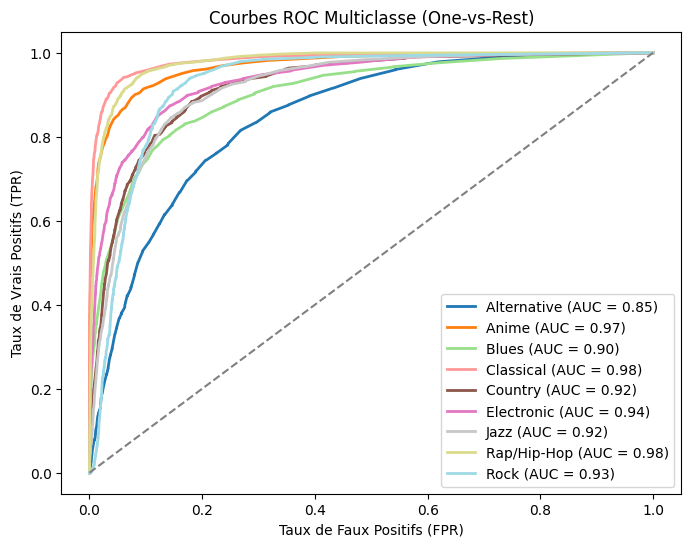

----------------------------------------------------------------------------------------------------


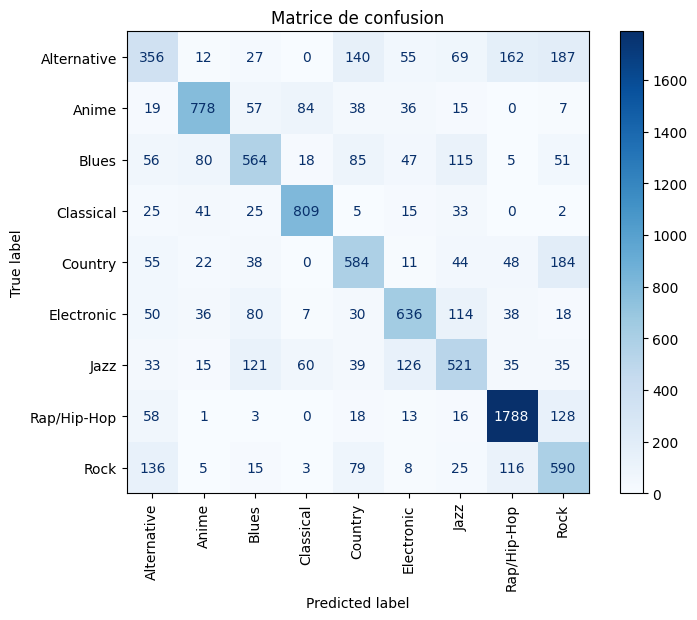

----------------------------------------------------------------------------------------------------


In [4]:
src.evaluate_model(forest_default, X_test, y_test, classes=config.CLASSES_COMBINED_RAP_HIPHOP)

Scores seem to be slightly better.  
Let's try to optimize the parameters of the forest now.

In [ ]:
n_trees = np.arange(100, 1000, 100)

train_scores = []
test_scores = []

for n in n_trees:
    print(f'-> {n} trees.')

    forest = RandomForestClassifier(random_state=0, oob_score=True, n_estimators=n, n_jobs=2)
    forest.fit(X_train, y_train)

    y_pred_train = forest.predict(X_train)
    y_pred_test = forest.predict(X_test)

    train_score = accuracy_score(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.4)

ax1.plot(n_trees, train_scores, label='Train', color='C0')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('score')

ax2.plot(n_trees, test_scores, label='Test', color='C1')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('score')

fig.suptitle('Score evolution over number of trees')

ax1.legend()
ax2.legend()

plt.show()

Using more trees doesn't seem to improve the score so we'll keep their number at $100$.  
Now we're going to optimize simultaneously `max_depth` and `max_features` parameters.

In [ ]:
params = {
    'max_depth' : np.arange(1, 45, 5),
    'max_features' : np.arange(1, X_train.shape[1], 5)
}

forest = RandomForestClassifier(random_state=0, oob_score=True)
score = make_scorer(accuracy_score)

gs = GridSearchCV(forest, param_grid=params, scoring=score, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

In [ ]:
scores = gs.cv_results_['mean_test_score']
scores = scores.reshape(len(params['max_depth']), len(params['max_features']))

fig, ax = plt.subplots(figsize=(5,6))

heatmap = sns.heatmap(scores, linewidths=0, cmap='Reds', cbar=True, cbar_kws={'label': 'accuracy_score'})

ax.set_xticks(np.arange(len(params['max_features'])))
ax.set_yticks(np.arange(len(params['max_depth'])))

ax.set_xticklabels(params['max_features'])
ax.set_yticklabels(params['max_depth'])

ax.set_xlabel('max_features')
ax.set_ylabel('max_depth')

# colorbar = ax.figure.colorbar(heatmap)
# colorbar.set_label('accuracy_score')

plt.title('Accuracy score for different values of max_depth and max_features', pad=20)
plt.show()

In [ ]:
best_max_depth = gs.best_params_['max_depth']
best_max_features = gs.best_params_['max_features']

print(f'Best value for \'max_depth\' is : {best_max_depth}.')
print(f'Best value for \'max_features\' is : {best_max_features}.')

In [ ]:
best_forest = RandomForestClassifier(random_state=0, oob_score=True, max_depth=11, max_features=11)
best_forest.fit(X_train, y_train)

In [ ]:
y_pred_train = best_forest.predict(X_train)
y_pred_test = best_forest.predict(X_test)

forest_score_train = accuracy_score(y_train, y_pred_train)
forest_score_test = accuracy_score(y_test, y_pred_test)

print(f'Score on train : {forest_score_train}.')
print(f'Score on test : {forest_score_test}.')

In [ ]:
print(classification_report(y_test, y_pred_test))

Score is better by 2%, not very satisfying...